In [ ]:
!pip install pulp pyomo gekko

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!

In [ ]:
import random
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def generate_data(size):
    """Generates a random distance matrix based on the given size."""
    distance_matrix = []
    for i in range(size):
        row = []
        for j in range(size):
            if i == j:
                row.append(0)
            else:
                row.append(random.randint(10, 100))  # Random distance between 10 and 100 miles
        distance_matrix.append(row)
    return distance_matrix


def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance} miles\n"


def main():
    """Entry point of the program."""
    # Sizes to test
    sizes = [5, 10, 15, 20]  # Example sizes for the TSP problem

    for size in sizes:
        print(f"Solving TSP for {size} cities")

        # Generate random data for the current size
        distance_matrix = generate_data(size)
        data = create_data_model(distance_matrix)

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
            len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
        )

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)

        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data["distance_matrix"][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        )

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        # Print solution on console.
        if solution:
            print_solution(manager, routing, solution)
        else:
            print("No solution found.")

if __name__ == "__main__":
    main()


Solving TSP for 5 cities
Objective: 131 miles
Route for vehicle 0:
 0 -> 1 -> 3 -> 4 -> 2 -> 0

Solving TSP for 10 cities
Objective: 290 miles
Route for vehicle 0:
 0 -> 9 -> 7 -> 4 -> 6 -> 5 -> 8 -> 1 -> 3 -> 2 -> 0

Solving TSP for 15 cities
Objective: 336 miles
Route for vehicle 0:
 0 -> 5 -> 2 -> 8 -> 7 -> 9 -> 10 -> 3 -> 14 -> 4 -> 11 -> 13 -> 6 -> 12 -> 1 -> 0

Solving TSP for 20 cities
Objective: 378 miles
Route for vehicle 0:
 0 -> 1 -> 11 -> 12 -> 13 -> 7 -> 6 -> 9 -> 5 -> 2 -> 18 -> 15 -> 10 -> 17 -> 8 -> 14 -> 4 -> 19 -> 16 -> 3 -> 0



### Time elapsed

In [ ]:
import random
import time
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import itertools
import pulp

def solve_tsp(distance_matrix):
    num_cities = len(distance_matrix)

    # Define the problem
    model = pulp.LpProblem("TSP", pulp.LpMinimize)

    # Variables: Binary variables to decide if city i is connected to city j
    x = pulp.LpVariable.dicts("x", [(i, j) for i in range(num_cities) for j in range(num_cities)], cat="Binary")

    # Objective: Minimize total travel distance
    model += pulp.lpSum(distance_matrix[i][j] * x[i, j] for i in range(num_cities) for j in range(num_cities) if i != j)

    # Constraints
    # 1. Each city must be entered and left exactly once
    for i in range(num_cities):
        model += pulp.lpSum(x[i, j] for j in range(num_cities) if i != j) == 1
        model += pulp.lpSum(x[j, i] for j in range(num_cities) if i != j) == 1

    # Subtour elimination (to prevent smaller loops within the tour)
    u = pulp.LpVariable.dicts("u", range(num_cities), lowBound=0, upBound=num_cities-1, cat="Integer")
    for i in range(1, num_cities):
        for j in range(1, num_cities):
            if i != j:
                model += u[i] - u[j] + num_cities * x[i, j] <= num_cities - 1

    # Solve the model
    model.solve()

    # # Check if solution is optimal
    # if model.status == pulp.LpStatusOptimal:
    #     # Extract the tour
    #     tour = []
    #     current_city = 0  # assuming the tour starts from city 0 (depot)
    #     while len(tour) < num_cities:
    #         for j in range(num_cities):
    #             if pulp.value(x[current_city, j]) == 1:
    #                 tour.append(j)
    #                 current_city = j
    #                 break

    #     # Calculate total distance
    #     total_distance = pulp.value(model.objective)
    #     print("Tour:", tour)
    #     print("Total Distance:", total_distance)
    # else:
    #     print("No optimal solution found.")

def held_karp(dist):
    """
    Held-Karp algorithm to solve TSP
    :param dist: distance matrix
    :return: minimum cost and the path
    """
    n = len(dist)
    C = {}

    # Initialize the dictionary C with distances between pairs of cities
    for i in range(1, n):
        C[(i, frozenset([i]))] = dist[0][i]

    # Solve the problem using dynamic programming
    for size in range(2, n):
        for subset in itertools.combinations(range(1, n), size):
            subset = frozenset(subset)
            for next_node in subset:
                prev_subset = subset - frozenset([next_node])
                C[(next_node, subset)] = min(
                    C[(k, prev_subset)] + dist[k][next_node]
                    for k in prev_subset
                )

    # Reconstruct the optimal path
    tour = []
    subset = frozenset(range(1, n))
    last_node = 0
    while subset:
        # Find the node that leads to the minimum cost
        next_node = min(
            subset,
            key=lambda x: C[(x, subset)] + dist[x][last_node]
        )
        tour.append(last_node)
        subset = subset - frozenset([next_node])
        last_node = next_node

    # Add the starting node to complete the cycle
    tour.append(last_node)
    tour.append(0)  # Return to the starting point

def generate_data(size):
    """Generates a random distance matrix based on the given size."""
    distance_matrix = []
    for i in range(size):
        row = []
        for j in range(size):
            if i == j:
                row.append(0)
            else:
                row.append(random.randint(10, 100))  # Random distance between 10 and 100 miles
        distance_matrix.append(row)
    return distance_matrix


def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance} miles\n"

time_or=[]
time_dp=[]
time_pulp=[]
sizes=[10,20,30,40,50,70,100,150,200,250,300]
dist=[]
for n in sizes:
    distance_matrix = generate_data(n)
    dist.append(distance_matrix)
def f(time_or,time_dp,dist):
    """Entry point of the program."""
    for size, distance_matrix in enumerate(dist):
        print(f"Solving TSP for {size} cities")

        # # Generate random data for the current size
        # distance_matrix = generate_data(size)
        data = create_data_model(distance_matrix)

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
            len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
        )

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)

        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data["distance_matrix"][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
        )

        # Start timing
        start_time = time.time()

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        # End timing
        end_time = time.time()
        # # Print solution on console.
        # if solution:
        #     print_solution(manager, routing, solution)
        # else:
        #     print("No solution found.")

        # # Print time taken
        elapsed_time = end_time - start_time
        time_or.append(elapsed_time)
        # start_time = time.time()
        # held_karp(distance_matrix)
        # end_time = time.time()
        # t=end_time - start_time
        # time_dp.append(t)
        start_time = time.time()
        solve_tsp(distance_matrix)
        end_time = time.time()
        t=end_time - start_time
        time_pulp.append(t)

f(time_or,time_dp,dist)

Solving TSP for 0 cities
Solving TSP for 1 cities
Solving TSP for 2 cities
Solving TSP for 3 cities
Solving TSP for 4 cities
Solving TSP for 5 cities
Solving TSP for 6 cities
Solving TSP for 7 cities
Solving TSP for 8 cities
Solving TSP for 9 cities
Solving TSP for 10 cities


In [ ]:
time_or

[0.002362966537475586,
 0.011350631713867188,
 0.02198052406311035,
 0.053913116455078125,
 0.10304450988769531,
 0.28005290031433105,
 0.31662750244140625,
 0.9609634876251221,
 2.188504457473755,
 2.7395284175872803,
 8.911316394805908]

In [ ]:
time_dp

[]

In [ ]:
time_pulp

[0.15700912475585938,
 0.3452935218811035,
 1.0530142784118652,
 4.620120525360107,
 12.144517421722412,
 2.838992118835449,
 69.7533233165741,
 339.06629395484924,
 171.72476267814636,
 249.30227208137512,
 637.3562550544739]

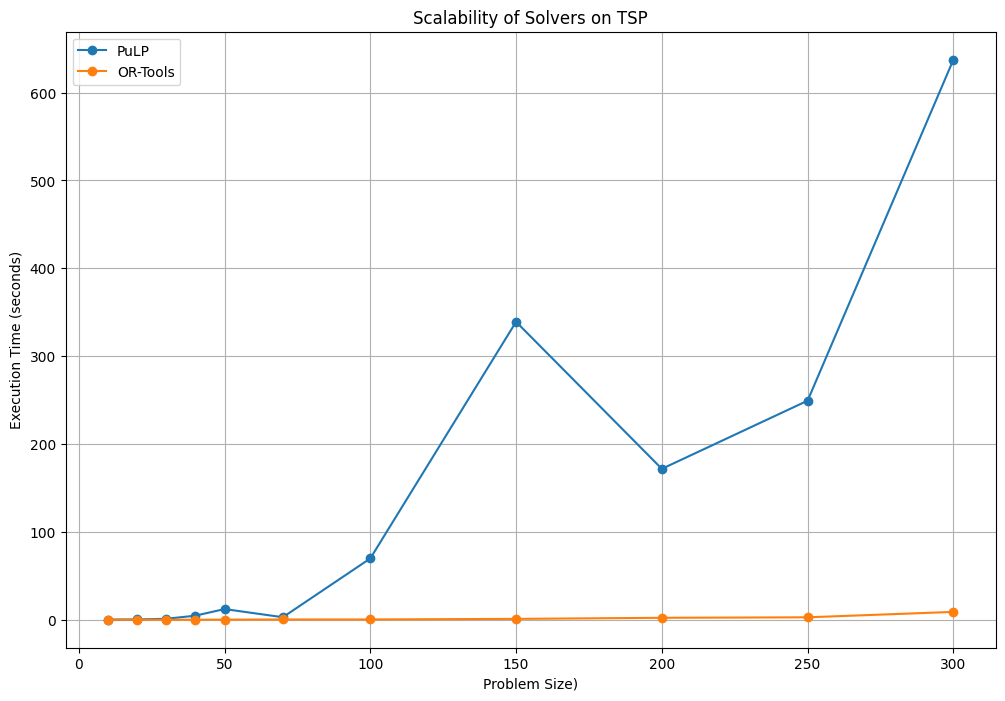

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for solver, times in zip(['PuLP', 'OR-Tools'], [time_pulp, time_or]):
    plt.plot(sizes, times, marker='o', label=solver)

plt.xlabel('Problem Size)')
plt.ylabel('Execution Time (seconds)')
plt.title('Scalability of Solvers on TSP')
plt.legend()
plt.grid(True)
# plt.yscale('log')  # Log scale if execution times vary widely
plt.show()


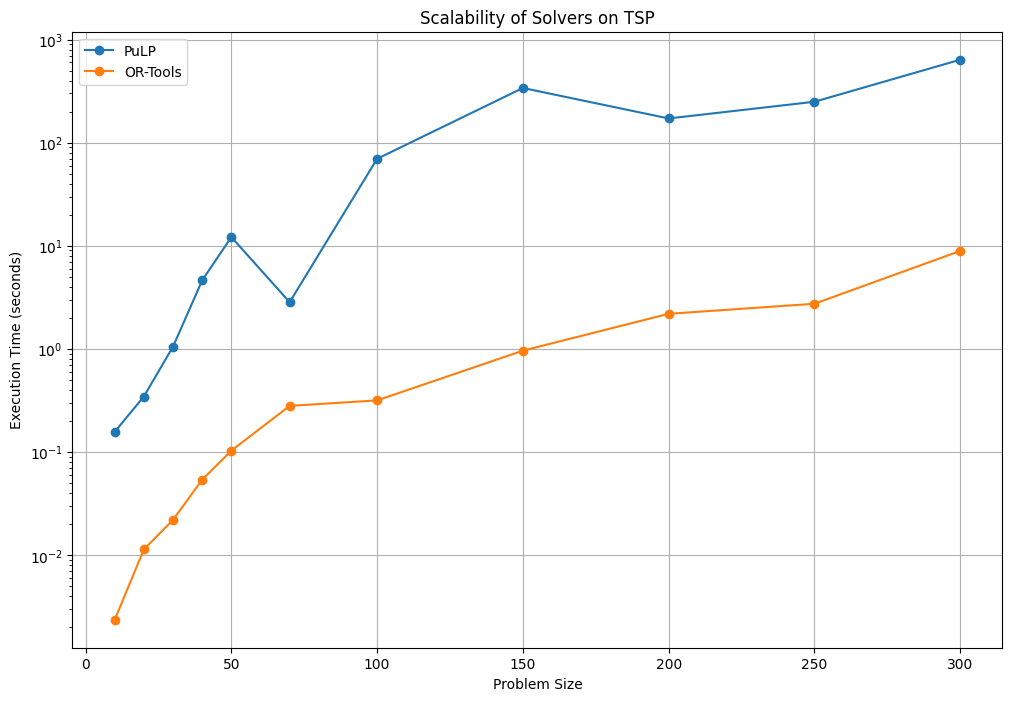

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for solver, times in zip(['PuLP', 'OR-Tools'], [time_pulp, time_or]):
    plt.plot(sizes, times, marker='o', label=solver)

plt.xlabel('Problem Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Scalability of Solvers on TSP')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Log scale if execution times vary widely
plt.show()


In [ ]:
"""Simple Travelling Salesperson Problem (TSP) between cities."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}miles\n"


def f(distance_matrix):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)

for i in dist:
  f(i)

Objective: 249 miles
Route for vehicle 0:
 0 -> 9 -> 3 -> 5 -> 4 -> 7 -> 8 -> 2 -> 1 -> 6 -> 0

Objective: 364 miles
Route for vehicle 0:
 0 -> 15 -> 5 -> 3 -> 19 -> 9 -> 10 -> 17 -> 13 -> 12 -> 11 -> 14 -> 4 -> 16 -> 7 -> 1 -> 2 -> 6 -> 8 -> 18 -> 0

Objective: 509 miles
Route for vehicle 0:
 0 -> 23 -> 24 -> 18 -> 8 -> 11 -> 12 -> 2 -> 1 -> 25 -> 20 -> 21 -> 6 -> 4 -> 9 -> 17 -> 16 -> 19 -> 10 -> 29 -> 22 -> 3 -> 7 -> 13 -> 26 -> 28 -> 14 -> 15 -> 27 -> 5 -> 0

Objective: 605 miles
Route for vehicle 0:
 0 -> 18 -> 23 -> 30 -> 22 -> 34 -> 3 -> 1 -> 39 -> 5 -> 37 -> 29 -> 36 -> 6 -> 7 -> 17 -> 35 -> 10 -> 14 -> 4 -> 13 -> 32 -> 12 -> 16 -> 11 -> 19 -> 2 -> 20 -> 38 -> 9 -> 28 -> 26 -> 15 -> 24 -> 8 -> 27 -> 21 -> 25 -> 31 -> 33 -> 0



In [ ]:
import itertools

def held_karp(dist):
    """
    Held-Karp algorithm to solve TSP
    :param dist: distance matrix
    :return: minimum cost and the path
    """
    n = len(dist)
    C = {}

    # Initialize the dictionary C with distances between pairs of cities
    for i in range(1, n):
        C[(i, frozenset([i]))] = dist[0][i]

    # Solve the problem using dynamic programming
    for size in range(2, n):
        for subset in itertools.combinations(range(1, n), size):
            subset = frozenset(subset)
            for next_node in subset:
                prev_subset = subset - frozenset([next_node])
                C[(next_node, subset)] = min(
                    C[(k, prev_subset)] + dist[k][next_node]
                    for k in prev_subset
                )

    # Reconstruct the optimal path
    tour = []
    subset = frozenset(range(1, n))
    last_node = 0
    while subset:
        # Find the node that leads to the minimum cost
        next_node = min(
            subset,
            key=lambda x: C[(x, subset)] + dist[x][last_node]
        )
        tour.append(last_node)
        subset = subset - frozenset([next_node])
        last_node = next_node

    # Add the starting node to complete the cycle
    tour.append(last_node)
    tour.append(0)  # Return to the starting point

    # Calculate the minimum cost by including the return to the start
    min_cost = sum(dist[tour[i]][tour[i+1]] for i in range(len(tour) - 1))

    return min_cost, tour

def main():
    # Example distance matrix for the TSP
    dist = [[0, 28, 37, 91, 46, 38, 90, 93, 38, 21],
 [25, 0, 35, 76, 30, 46, 22, 34, 42, 15],
 [20, 18, 0, 100, 57, 83, 96, 22, 85, 91],
 [13, 38, 77, 0, 67, 12, 29, 100, 22, 63],
 [51, 56, 50, 12, 0, 16, 49, 21, 77, 35],
 [94, 78, 86, 100, 21, 0, 18, 58, 24, 83],
 [26, 88, 44, 91, 57, 23, 0, 60, 91, 46],
 [48, 22, 75, 59, 39, 11, 41, 0, 41, 98],
 [75, 100, 53, 71, 98, 81, 82, 98, 0, 98],
 [47, 49, 100, 14, 69, 71, 48, 43, 60, 0]]
    # Compute the optimal solution using Held-Karp algorithm
    min_cost, tour = held_karp(dist)
    print(f"Minimum cost: {min_cost}")
    print(f"Optimal path: {tour}")

if __name__ == "__main__":
    main()


Minimum cost: 567
Optimal path: [0, 6, 5, 7, 4, 1, 2, 8, 3, 9, 0]


In [ ]:
import pulp

def solve_tsp(distance_matrix):
    num_cities = len(distance_matrix)

    # Define the problem
    model = pulp.LpProblem("TSP", pulp.LpMinimize)

    # Variables: Binary variables to decide if city i is connected to city j
    x = pulp.LpVariable.dicts("x", [(i, j) for i in range(num_cities) for j in range(num_cities)], cat="Binary")

    # Objective: Minimize total travel distance
    model += pulp.lpSum(distance_matrix[i][j] * x[i, j] for i in range(num_cities) for j in range(num_cities) if i != j)

    # Constraints
    # 1. Each city must be entered and left exactly once
    for i in range(num_cities):
        model += pulp.lpSum(x[i, j] for j in range(num_cities) if i != j) == 1
        model += pulp.lpSum(x[j, i] for j in range(num_cities) if i != j) == 1

    # Subtour elimination (to prevent smaller loops within the tour)
    u = pulp.LpVariable.dicts("u", range(num_cities), lowBound=0, upBound=num_cities-1, cat="Integer")
    for i in range(1, num_cities):
        for j in range(1, num_cities):
            if i != j:
                model += u[i] - u[j] + num_cities * x[i, j] <= num_cities - 1

    # Solve the model
    model.solve()

    # Check if solution is optimal
    if model.status == pulp.LpStatusOptimal:
        # Extract the tour
        tour = []
        current_city = 0  # assuming the tour starts from city 0 (depot)
        while len(tour) < num_cities:
            for j in range(num_cities):
                if pulp.value(x[current_city, j]) == 1:
                    tour.append(j)
                    current_city = j
                    break

        # Calculate total distance
        total_distance = pulp.value(model.objective)
        print("Tour:", tour)
        print("Total Distance:", total_distance)
    else:
        print("No optimal solution found.")

# Example usage
# for distance_matrix in dist:
solve_tsp(dist[0])


Tour: [9, 3, 8, 2, 1, 4, 7, 5, 6, 0]
Total Distance: 234.0


In [ ]:
dist[0]

[[0, 28, 37, 91, 46, 38, 90, 93, 38, 21],
 [25, 0, 35, 76, 30, 46, 22, 34, 42, 15],
 [20, 18, 0, 100, 57, 83, 96, 22, 85, 91],
 [13, 38, 77, 0, 67, 12, 29, 100, 22, 63],
 [51, 56, 50, 12, 0, 16, 49, 21, 77, 35],
 [94, 78, 86, 100, 21, 0, 18, 58, 24, 83],
 [26, 88, 44, 91, 57, 23, 0, 60, 91, 46],
 [48, 22, 75, 59, 39, 11, 41, 0, 41, 98],
 [75, 100, 53, 71, 98, 81, 82, 98, 0, 98],
 [47, 49, 100, 14, 69, 71, 48, 43, 60, 0]]

In [ ]:
# Open a file to write
with open('array_2d111.txt', 'w') as file:
    for row in dist:
        # Join the elements of each row as a string and write it to the file
        file.write("\t".join(map(str, row)) + "\n")

print("Array saved successfully to 'array_2d.txt'!")

Array saved successfully to 'array_2d.txt'!


In [ ]:
import pandas as pd

In [ ]:
df=pd.DataFrame({'size':sizes, 'pulp': time_pulp, 'OR-Tools': time_or})

In [ ]:
df.to_csv('TSP.csv',index=None)

#New

In [ ]:
pip install pulp ortools gurobipy matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3,

In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, PULP_CBC_CMD
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from gurobipy import Model, GRB, quicksum

# Generate a random distance matrix
def generate_distance_matrix(n):
    np.random.seed(42)
    return np.random.randint(1, 100, size=(n, n))

# PuLP Implementation
def solve_tsp_pulp(distance_matrix):
    n = len(distance_matrix)
    prob = LpProblem("TSP", LpMinimize)
    x = LpVariable.dicts("x", [(i, j) for i in range(n) for j in range(n)], cat="Binary")
    u = LpVariable.dicts("u", [i for i in range(n)], lowBound=0, upBound=n - 1, cat="Continuous")

    # Objective function
    prob += lpSum(distance_matrix[i][j] * x[(i, j)] for i in range(n) for j in range(n) if i != j)

    # Constraints
    for i in range(n):
        prob += lpSum(x[(i, j)] for j in range(n) if i != j) == 1
        prob += lpSum(x[(j, i)] for j in range(n) if i != j) == 1

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                prob += u[i] - u[j] + (n - 1) * x[(i, j)] <= n - 2

    # Solve
    start = time.time()
    prob.solve(PULP_CBC_CMD(msg=False))
    return time.time() - start

# Google OR-Tools Implementation
def solve_tsp_ortools(distance_matrix):
    n = len(distance_matrix)
    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = 30

    start = time.time()
    routing.SolveWithParameters(search_parameters)
    return time.time() - start

# Gurobi Implementation
def solve_tsp_gurobi(distance_matrix):
    n = len(distance_matrix)
    model = Model("TSP")
    model.setParam("OutputFlag", 0)

    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")
    u = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=n - 1, name="u")

    model.setObjective(quicksum(distance_matrix[i][j] * x[i, j] for i in range(n) for j in range(n) if i != j), GRB.MINIMIZE)

    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(n) if i != j) == 1)
        model.addConstr(quicksum(x[j, i] for j in range(n) if i != j) == 1)

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                model.addConstr(u[i] - u[j] + (n - 1) * x[i, j] <= n - 2)

    start = time.time()
    model.optimize()
    return time.time() - start


In [ ]:

# Main: Solve TSP and Plot Results
sizes = [5, 10, 15, 20, 25]  # Problem sizes (number of cities)
time_pulp, time_ortools, time_gurobi = [], [], []

for n in sizes:
    print(f"Solving TSP for {n} cities...")
    distance_matrix = generate_distance_matrix(n)

    # PuLP
    time_pulp.append(solve_tsp_pulp(distance_matrix))

    # OR-Tools
    time_ortools.append(solve_tsp_ortools(distance_matrix))

    # Gurobi
    time_gurobi.append(solve_tsp_gurobi(distance_matrix))






Solving TSP for 5 cities...
Restricted license - for non-production use only - expires 2026-11-23
Solving TSP for 10 cities...
Solving TSP for 15 cities...
Solving TSP for 20 cities...
Solving TSP for 25 cities...


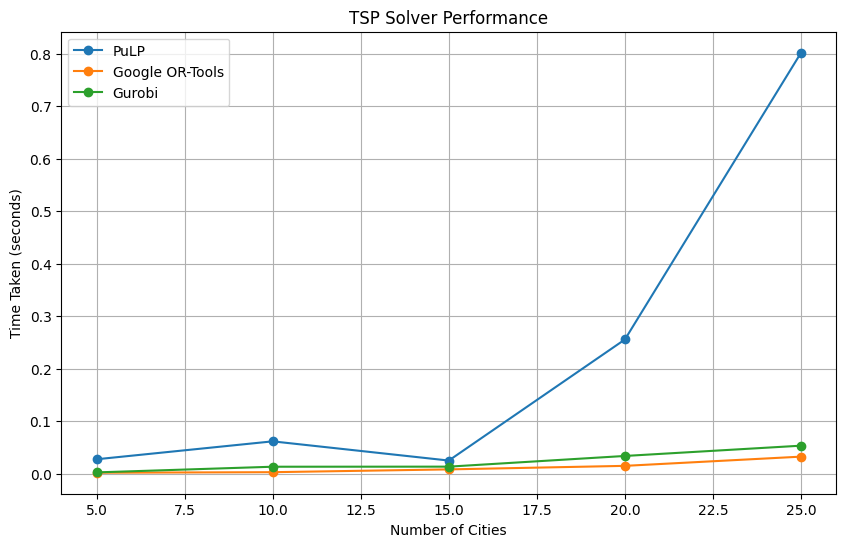

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_pulp, label="PuLP", marker="o")
plt.plot(sizes, time_ortools, label="Google OR-Tools", marker="o")
plt.plot(sizes, time_gurobi, label="Gurobi", marker="o")
plt.xlabel("Number of Cities")
plt.ylabel("Time Taken (seconds)")
plt.title("TSP Solver Performance")
plt.legend()
plt.grid()
plt.show()

Solving TSP for 10 cities...
Solving TSP for 12 cities...
Solving TSP for 14 cities...
Solving TSP for 16 cities...
Solving TSP for 18 cities...
Solving TSP for 20 cities...
Solving TSP for 22 cities...
Solving TSP for 24 cities...
Solving TSP for 26 cities...
Solving TSP for 28 cities...
Solving TSP for 30 cities...
Solving TSP for 32 cities...
Solving TSP for 34 cities...
Solving TSP for 36 cities...
Solving TSP for 38 cities...
Solving TSP for 40 cities...
Solving TSP for 42 cities...
Solving TSP for 44 cities...


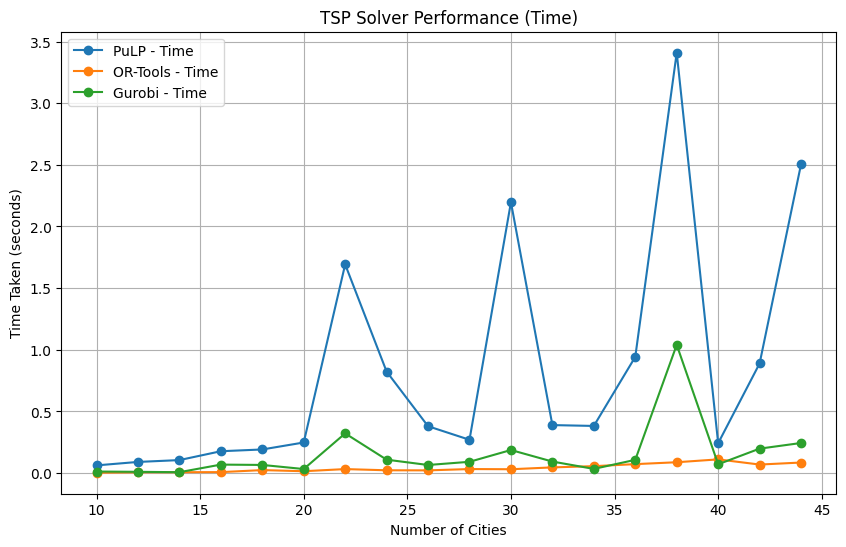

In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, PULP_CBC_CMD, value
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from gurobipy import Model, GRB, quicksum

# Generate a random distance matrix
def generate_distance_matrix(n):
    np.random.seed(42)
    return np.random.randint(1, 100, size=(n, n))

# PuLP Implementation
def solve_tsp_pulp(distance_matrix):
    n = len(distance_matrix)
    prob = LpProblem("TSP", LpMinimize)
    x = LpVariable.dicts("x", [(i, j) for i in range(n) for j in range(n)], cat="Binary")
    u = LpVariable.dicts("u", [i for i in range(n)], lowBound=0, upBound=n - 1, cat="Continuous")

    # Objective function
    prob += lpSum(distance_matrix[i][j] * x[(i, j)] for i in range(n) for j in range(n) if i != j)

    # Constraints
    for i in range(n):
        prob += lpSum(x[(i, j)] for j in range(n) if i != j) == 1
        prob += lpSum(x[(j, i)] for j in range(n) if i != j) == 1

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                prob += u[i] - u[j] + (n - 1) * x[(i, j)] <= n - 2

    # Solve
    start = time.time()
    prob.solve(PULP_CBC_CMD(msg=False))
    end = time.time()

    # Calculate objective value
    objective_value = value(prob.objective)
    return end - start, objective_value

# Google OR-Tools Implementation
def solve_tsp_ortools(distance_matrix):
    n = len(distance_matrix)
    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = 30

    start = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    end = time.time()

    # Calculate objective value
    if solution:
        objective_value = solution.ObjectiveValue()
    else:
        objective_value = None

    return end - start, objective_value

# Gurobi Implementation
def solve_tsp_gurobi(distance_matrix):
    n = len(distance_matrix)
    model = Model("TSP")
    model.setParam("OutputFlag", 0)

    x = model.addVars(n, n, vtype=GRB.BINARY, name="x")
    u = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=n - 1, name="u")

    model.setObjective(quicksum(distance_matrix[i][j] * x[i, j] for i in range(n) for j in range(n) if i != j), GRB.MINIMIZE)

    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(n) if i != j) == 1)
        model.addConstr(quicksum(x[j, i] for j in range(n) if i != j) == 1)

    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                model.addConstr(u[i] - u[j] + (n - 1) * x[i, j] <= n - 2)

    start = time.time()
    model.optimize()
    end = time.time()

    # Calculate objective value
    if model.status == GRB.OPTIMAL:
        objective_value = model.objVal
    else:
        objective_value = None

    return end - start, objective_value

# Main: Solve TSP and Plot Results
sizes = list(range(10, 45, 2))  # Problem sizes (number of cities)
time_pulp, time_ortools, time_gurobi = [], [], []
obj_pulp, obj_ortools, obj_gurobi = [], [], []

for n in sizes:
    print(f"Solving TSP for {n} cities...")
    distance_matrix = generate_distance_matrix(n)

    # PuLP
    t_pulp, obj_p = solve_tsp_pulp(distance_matrix)
    time_pulp.append(t_pulp)
    obj_pulp.append(obj_p)

    # OR-Tools
    t_ortools, obj_o = solve_tsp_ortools(distance_matrix)
    time_ortools.append(t_ortools)
    obj_ortools.append(obj_o)

    # Gurobi
    t_gurobi, obj_g = solve_tsp_gurobi(distance_matrix)
    time_gurobi.append(t_gurobi)
    obj_gurobi.append(obj_g)

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_pulp, label="PuLP - Time", marker="o")
plt.plot(sizes, time_ortools, label="OR-Tools - Time", marker="o")
plt.plot(sizes, time_gurobi, label="Gurobi - Time", marker="o")
plt.xlabel("Number of Cities")
plt.ylabel("Time Taken (seconds)")
plt.title("TSP Solver Performance (Time)")
plt.yscale('log')  # Log scale if execution times vary widely

plt.legend()

plt.grid()
plt.show()


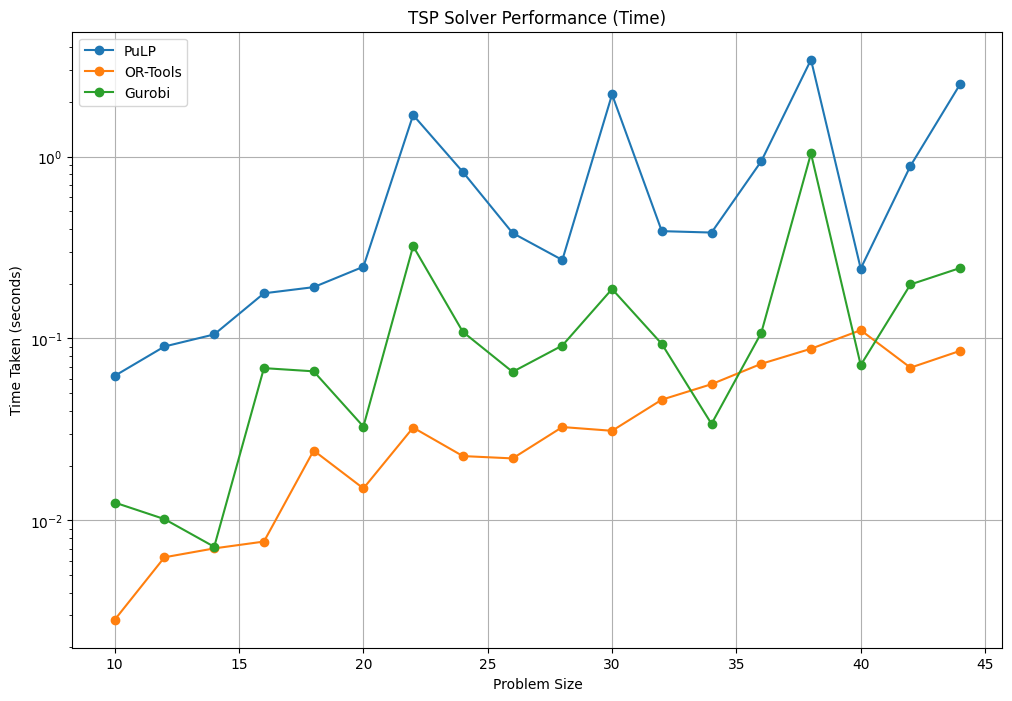

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(sizes, time_pulp, label="PuLP", marker="o")
plt.plot(sizes, time_ortools, label="OR-Tools", marker="o")
plt.plot(sizes, time_gurobi, label="Gurobi", marker="o")
plt.xlabel("Problem Size")
plt.ylabel("Time Taken (seconds)")
plt.title("TSP Solver Performance (Time)")
plt.yscale('log')  # Log scale if execution times vary widely

plt.legend()

plt.grid()
plt.show()

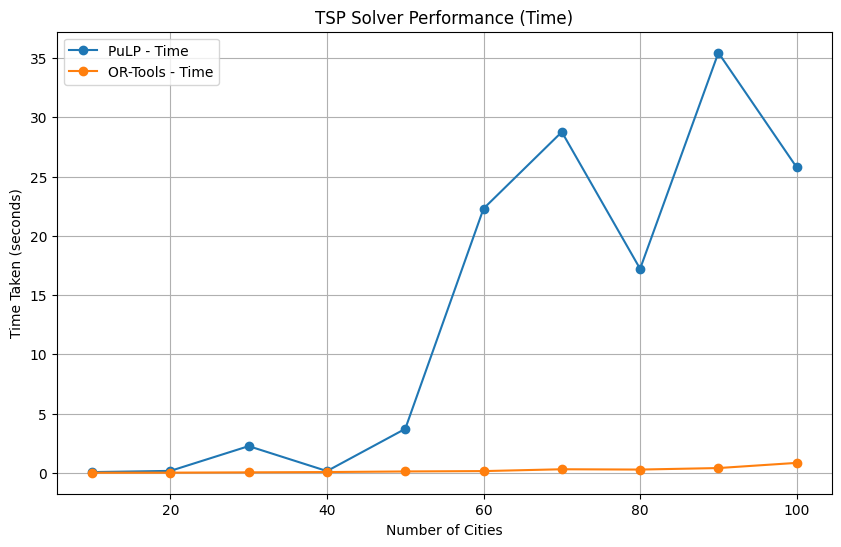

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_pulp, label="PuLP - Time", marker="o")
plt.plot(sizes, time_ortools, label="OR-Tools - Time", marker="o")
# plt.plot(sizes, time_gurobi, label="Gurobi - Time", marker="o")
plt.xlabel("Number of Cities")
plt.ylabel("Time Taken (seconds)")
plt.title("TSP Solver Performance (Time)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
obj_pulp

[120.0, 142.0, 110.0, 153.0, 171.0]

In [ ]:
obj_ortools

[120, 142, 110, 228, 226]

In [ ]:
obj_gurobi

[120.0, 142.0, 110.0, 153.0, 171.0]